# Model 1: one airline, one airport

Pitfalls 1 airline, 1 airport:
- unsufficient data: the least visited airports only have a few flights per month (unfit for linear regression)
- extreme delays: large delays create bias and significantly change the model (with small sets)

In [1]:
# package initialization
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge

In [2]:
# folder initialization
from functions import *
from data_loading import load_data

In [3]:
# load data
airlines = pd.read_csv('data/airlines.csv')
airports = pd.read_csv('data/airports.csv')
train = pd.read_csv('data/flights_train.csv')
test = pd.read_csv('data/flights_test.csv')
submit = pd.read_csv('data/submit_sample.csv')

In [4]:
# add DATE column
train['DATE'] = pd.to_datetime(train[['YEAR','MONTH', 'DAY']])
test['DATE'] = pd.to_datetime(test[['YEAR','MONTH', 'DAY']])

In [11]:
# a class to produce graphs
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])    

In [12]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

**Datetime functions**

In [5]:
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [6]:
def aggregate_date_time(values):
    if(len(values) == 5):
        year, month, day, time, departure = values
        year = int(year)
        month = int(month)
        day = int(day)
        time = int(time)

        hour, minutes = int(time/100), time % 100
        if(hour == 24):
            hour = 0
        dateTime = datetime.datetime(year, month, day, hour, minutes)
        if(dateTime < departure and (departure-dateTime).total_seconds()/60 > 50):
            return dateTime + datetime.timedelta(days=1)
        return dateTime

    year, month, day, time = [int(x) for x in values]
    hour, minutes = int(time/100), time % 100
    if(hour == 24):
        hour = 0
    return datetime.datetime(year, month, day, hour, minutes)

In [7]:
def aggregate_time_in_minutes(dateTime):
    return dateTime.hour*60 + dateTime.minute

In [8]:
def preprocessing(x):
    x['scheduled_departure_date_time'] = x[['YEAR', 'MONTH', 'DAY',
                                            'SCHEDULED_DEPARTURE']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['scheduled_departure_date'] = x['scheduled_departure_date_time'].apply(
        lambda x: x.date())
    x['scheduled_departure_timestamp'] = x['scheduled_departure_date_time'].apply(
        lambda x: x.timestamp())
    # x['scheduled_arrival_date_time'] = x[['YEAR', 'MONTH', 'DAY', 'SCHEDULED_ARRIVAL']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['departure_date_time'] = x[['YEAR', 'MONTH', 'DAY', 'DEPARTURE_TIME',
                                  'scheduled_departure_date_time']].apply(lambda x: aggregate_date_time(x), axis=1)
    x['departure_timestamp'] = x['departure_date_time'].apply(
        lambda x: x.timestamp())
    # x['scheduled_departure_minutes'] = x['scheduled_departure_date_time'].apply(lambda x: aggregate_time_in_minutes(x))
    x['DEPARTURE_DELAY'] = (x['departure_date_time'] -
                          x['scheduled_departure_date_time']).apply(lambda x: x.total_seconds() / 60)
    return x

**Preprocessing**

In [9]:
train = preprocessing(train)
test = preprocessing(test)

In [10]:
# modify train dataframe variables
train['SCHEDULED_DEPARTURE'] = create_flight_time(train, 'SCHEDULED_DEPARTURE')
train['DEPARTURE_TIME'] = train['DEPARTURE_TIME'].apply(format_heure)
train['SCHEDULED_ARRIVAL'] = train['SCHEDULED_ARRIVAL'].apply(format_heure)
# modify test dataframe variables
test['SCHEDULED_DEPARTURE'] = create_flight_time(test, 'SCHEDULED_DEPARTURE')
test['DEPARTURE_TIME'] = test['DEPARTURE_TIME'].apply(format_heure)
test['SCHEDULED_ARRIVAL'] = test['SCHEDULED_ARRIVAL'].apply(format_heure)

**American Airlines Statistics**
Least visited airports only have a few flights per month, not good enough for regression

In [14]:
carrier = 'AA'
check_airports = train[(train['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         train['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
GUC,-24.0,453.0,94.0,5.021277
ANC,-6.0,74.0,27.0,13.148148
XNA,-13.0,2.0,16.0,-7.437500
MTJ,-12.0,51.0,13.0,9.538462
LIT,-5.0,74.0,9.0,12.555556


**Polynomial Regression with cross-validation**

In [25]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

In [22]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'neg_mean_squared_error'))

**Determening the best polynomial order**

In [23]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 38 

n=1 -> MSE = 246.718
n=2 -> MSE = 386.595
n=3 -> MSE = 386.229
n=4 -> MSE = 251.397
n=5 -> MSE = 171.83
n=6 -> MSE = 901.946
n=7 -> MSE = 4835.191


In [26]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 1)
fit.predict(fit.X)

In [27]:
fit2.train(pol_order = 1, nb_folds = nb_folds)

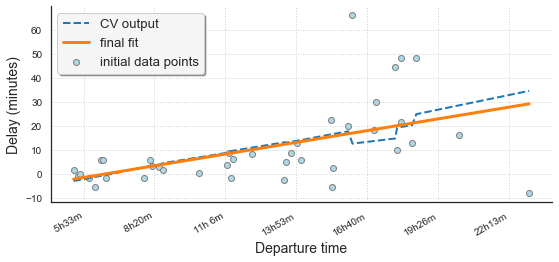

In [28]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [29]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

195.32109587550033

**Testing**

In [30]:
test_data = get_flight_delays(test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [31]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

137.28244178682667

**The difference in minutes between the predicted delay and the actual delay.**

In [32]:
'Difference = {:.2f} min'.format(np.sqrt(score))

'Difference = 11.72 min'